In [1]:
import numpy as np
import pandas as pd
import os
import pprint
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
import matplotlib
from os import listdir
import seaborn as sns
import scipy
import sys
import pickle
import miceforest as mf
warnings.filterwarnings("ignore")
import functools
from functools import reduce
from mc4.algorithm import mc4_aggregator
from copy import deepcopy

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingpy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, log_loss, roc_auc_score, auc
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from collections import Counter

import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm
from torch.utils.data import Dataset, DataLoader
from IPython.display import display

In [2]:
rs = 42

In [3]:
import random

def _init_fn(worker_id):
    np.random.seed(int(rs))
    
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [4]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [5]:
os.chdir('..')

In [6]:
prediction_window = ''

In [7]:
data_directory = 'Sepsis Data/'
prediction_directory = 'sepsis/'

data_files = find_csv_filenames(data_directory+prediction_directory)

hosps = [x.replace('.csv', '') for x in data_files]

### Loading in Model Performances

#### LR

In [8]:
model_directory = 'Sepsis Models/' + prediction_window + '/Pytorch LR/'

In [9]:
filename = model_directory + 'LocalModelPerformances.pckl'
performances = pickle.load(open(filename, 'rb'))
lr_local_models_performances, lr_local_models_stds, lr_local_models_roc_info = tuple(performances)

In [10]:
filename = model_directory + 'FedLocalModelPerformances.pckl'
performances = pickle.load(open(filename, 'rb'))
lr_fed_local_models_performances, lr_fed_local_models_stds, lr_fed_local_models_roc_info = tuple(performances)

In [11]:
filename = model_directory + 'AggLocalModelPerformances.pckl'
performances = pickle.load(open(filename, 'rb'))
lr_agg_local_models_performances, lr_agg_local_models_stds, lr_agg_local_models_roc_info = tuple(performances)

#### MLP

In [12]:
model_directory = 'Sepsis Models/' + prediction_window + '/Pytorch MLP/'

In [13]:
filename = model_directory + 'LocalModelPerformances.pckl'
performances = pickle.load(open(filename, 'rb'))
mlp_local_models_performances, mlp_local_models_stds, mlp_local_models_roc_info = tuple(performances)

In [14]:
filename = model_directory + 'FedLocalModelPerformances.pckl'
performances = pickle.load(open(filename, 'rb'))
mlp_fed_local_models_performances, mlp_fed_local_models_stds, mlp_fed_local_models_roc_info = tuple(performances)

In [15]:
filename = model_directory + 'AggLocalModelPerformances.pckl'
performances = pickle.load(open(filename, 'rb'))
mlp_agg_local_models_performances, mlp_agg_local_models_stds, mlp_agg_local_models_roc_info = tuple(performances)

## Plotting Performances

### LR

#### AUC Bar Plots

In [16]:
channel = ['Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated',
           'Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated',
           'Local', 'Pooled', 'Federated']
average_auc = []
std_auc = []
for hosp in hosps:
    average_auc.append(lr_local_models_performances[hosp][1][1])
    average_auc.append(lr_agg_local_models_performances[hosp][1][1])
    average_auc.append(lr_fed_local_models_performances[hosp][1][1])
    std_auc.append(lr_local_models_stds[hosp][1][1])
    std_auc.append(lr_agg_local_models_stds[hosp][1][1])
    std_auc.append(lr_fed_local_models_stds[hosp][1][1])

In [17]:
conc = np.repeat(hosps,3)
a = list(set(conc))
conc2 = [a.index(x) for x in conc]
conc2.sort()

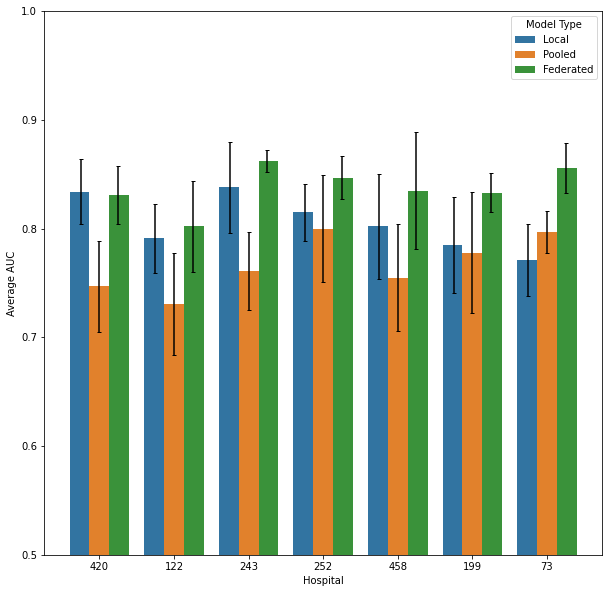

In [18]:
df = pd.DataFrame({"Model Type": channel,
                  "Average AUC": average_auc,
                  "sd" : std_auc,
                  "Hospital": conc})

order = hosps
plt.figure(figsize=(10,10))
plt.ylim(0.5, 1.0)
sns.barplot(x="Hospital", y="Average AUC", hue="Model Type", data=df, ci=None, 
            order=order)

width = .25
add = [-1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width,
      -1*width, 0 , width, -1*width, 0 , width]
x = np.array(conc2)+np.array(add)

plt.errorbar(x = x, y = df['Average AUC'],
            yerr=df['sd'], fmt='none', c= 'black', capsize = 2)
plt.show()

#### AUC ROC Curves

In [19]:
num_rows = 3
num_cols = 3

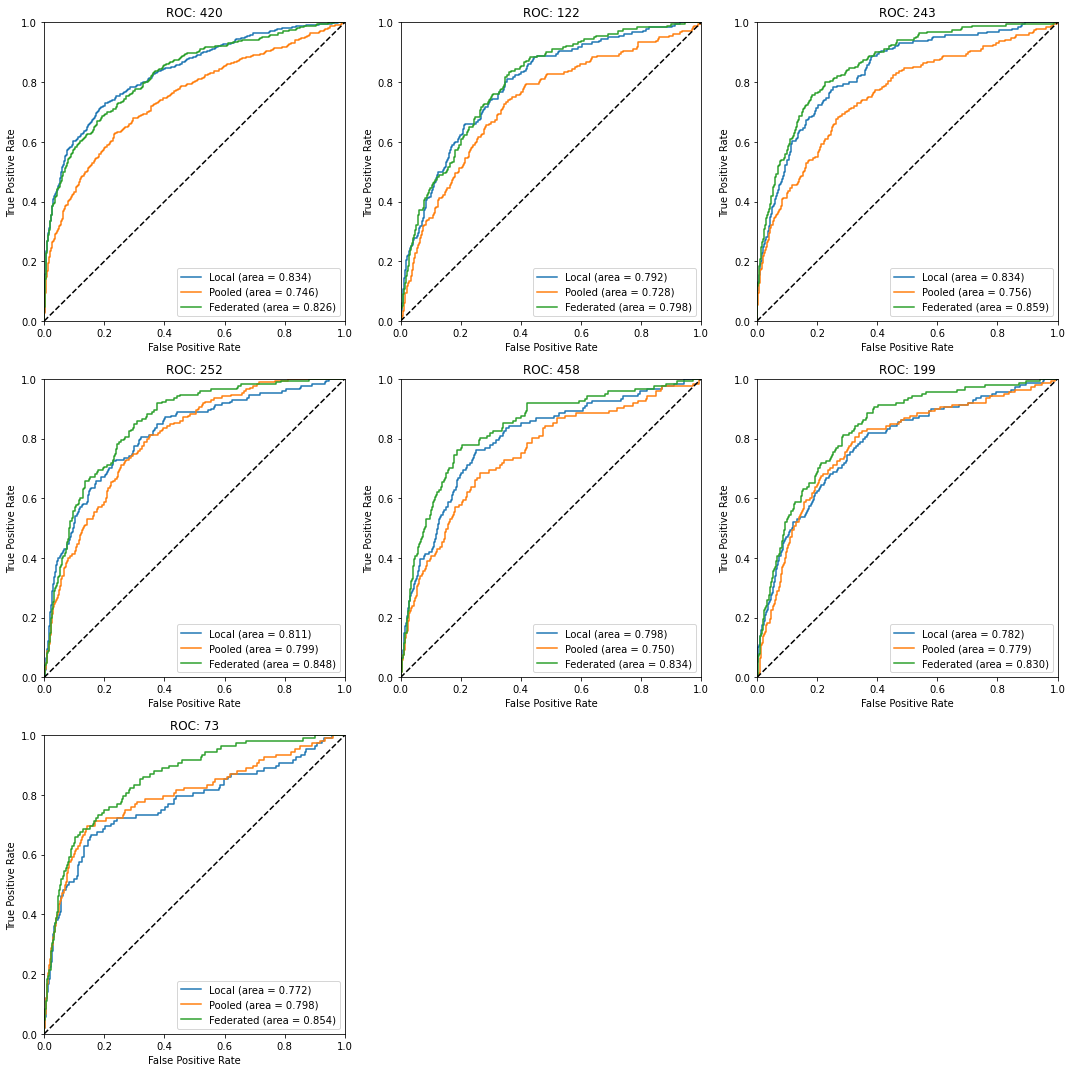

In [20]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,15))
fig.delaxes(axes[(2, 1)])
fig.delaxes(axes[(2, 2)])

for i, hosp in enumerate(hosps):
    fpr_l, tpr_l, t = lr_local_models_roc_info[hosp]
    roc_auc_l = auc(fpr_l, tpr_l)
    fpr_f, tpr_f, t = lr_fed_local_models_roc_info[hosp]
    roc_auc_f = auc(fpr_f, tpr_f)
    fpr_p, tpr_p, t = lr_agg_local_models_roc_info[hosp]
    roc_auc_p = auc(fpr_p, tpr_p)

    # Plot ROC curve
    ax = axes[divmod(i, num_cols)]
    ax.plot(fpr_l, tpr_l, label='Local (area = %0.3f)' % roc_auc_l)
    ax.plot(fpr_p, tpr_p, label='Pooled (area = %0.3f)' % roc_auc_p)
    ax.plot(fpr_f, tpr_f, label='Federated (area = %0.3f)' % roc_auc_f)
    ax.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC: {}'.format(hosp))
    ax.legend(loc="lower right")
    
plt.tight_layout()

### MLP

#### AUC Bar Plots

In [21]:
channel = ['Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated',
           'Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated', 'Local', 'Pooled', 'Federated',
           'Local', 'Pooled', 'Federated']
average_auc = []
std_auc = []
for hosp in hosps:
    average_auc.append(mlp_local_models_performances[hosp][1][1])
    average_auc.append(mlp_agg_local_models_performances[hosp][1][1])
    average_auc.append(mlp_fed_local_models_performances[hosp][1][1])
    std_auc.append(mlp_local_models_stds[hosp][1][1])
    std_auc.append(mlp_agg_local_models_stds[hosp][1][1])
    std_auc.append(mlp_fed_local_models_stds[hosp][1][1])

In [22]:
conc = np.repeat(hosps,3)
a = list(set(conc))
conc2 = [a.index(x) for x in conc]
conc2.sort()

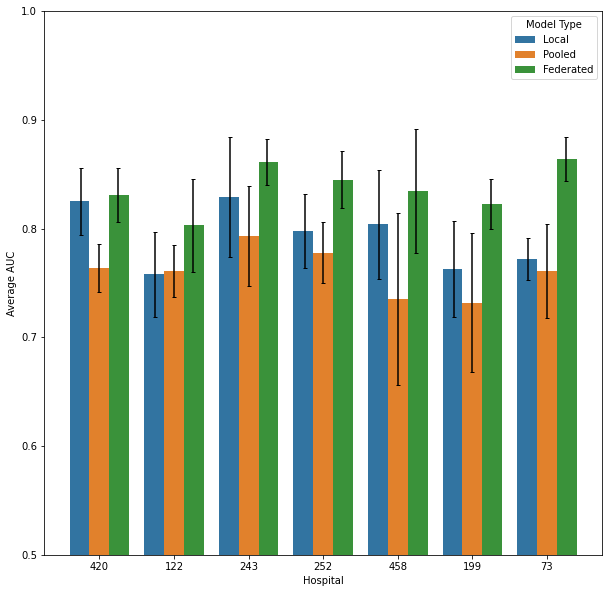

In [23]:
df = pd.DataFrame({"Model Type": channel,
                  "Average AUC": average_auc,
                  "sd" : std_auc,
                  "Hospital": conc})

order = hosps
plt.figure(figsize=(10,10))
plt.ylim(0.5, 1.0)
sns.barplot(x="Hospital", y="Average AUC", hue="Model Type", data=df, ci=None, 
            order=order)

width = .25
add = [-1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width,
      -1*width, 0 , width, -1*width, 0 , width]
x = np.array(conc2)+np.array(add)

plt.errorbar(x = x, y = df['Average AUC'],
            yerr=df['sd'], fmt='none', c= 'black', capsize = 2)
plt.show()

#### AUC ROC Curves

In [24]:
num_rows = 3
num_cols = 3

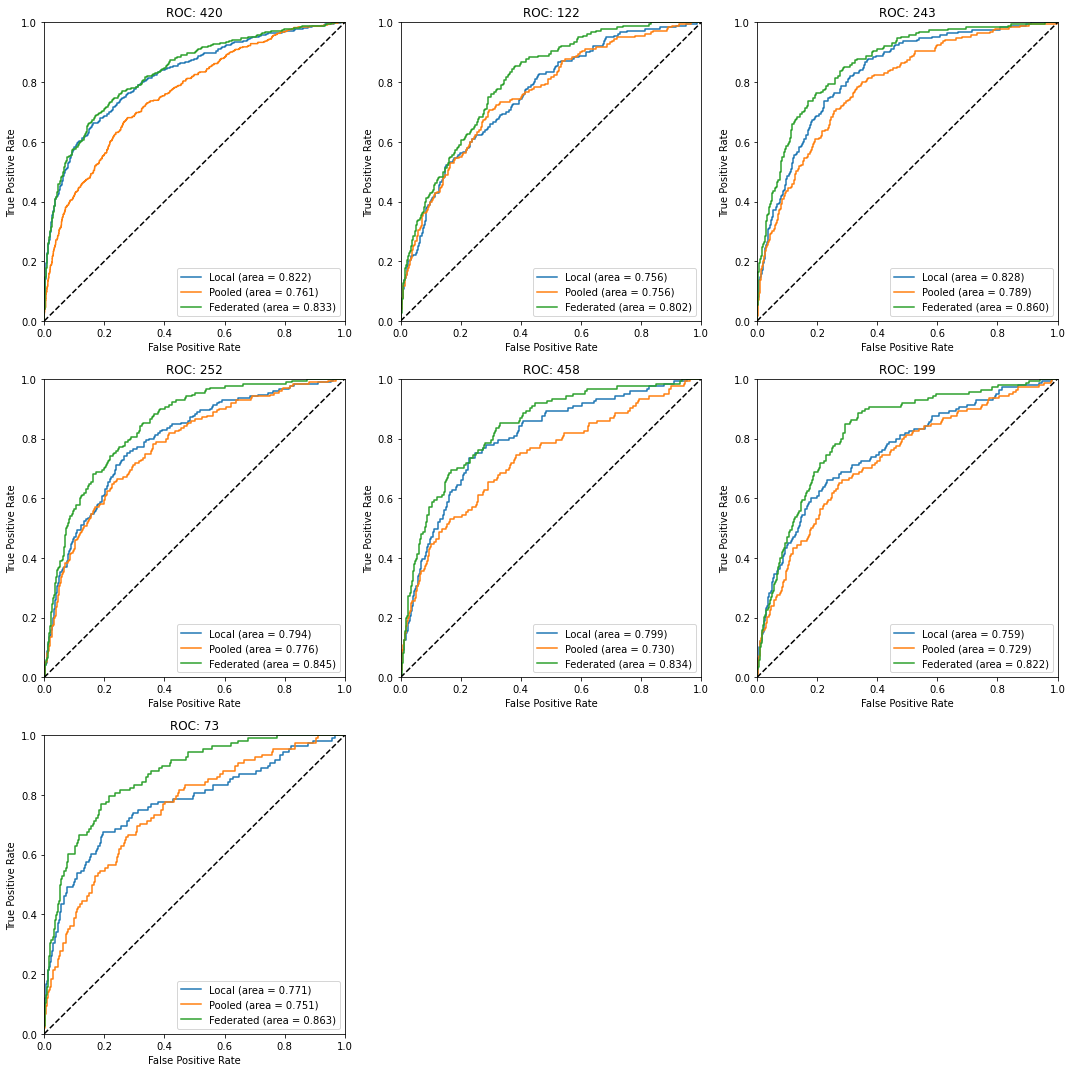

In [25]:
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,15))
fig.delaxes(axes[(2, 1)])
fig.delaxes(axes[(2, 2)])

for i, hosp in enumerate(hosps):
    fpr_l, tpr_l, t = mlp_local_models_roc_info[hosp]
    roc_auc_l = auc(fpr_l, tpr_l)
    fpr_f, tpr_f, t = mlp_fed_local_models_roc_info[hosp]
    roc_auc_f = auc(fpr_f, tpr_f)
    fpr_p, tpr_p, t = mlp_agg_local_models_roc_info[hosp]
    roc_auc_p = auc(fpr_p, tpr_p)

    # Plot ROC curve
    ax = axes[divmod(i, num_cols)]
    ax.plot(fpr_l, tpr_l, label='Local (area = %0.3f)' % roc_auc_l)
    ax.plot(fpr_p, tpr_p, label='Pooled (area = %0.3f)' % roc_auc_p)
    ax.plot(fpr_f, tpr_f, label='Federated (area = %0.3f)' % roc_auc_f)
    ax.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC: {}'.format(hosp))
    ax.legend(loc="lower right")
    
plt.tight_layout()

### Create Tables for Performances

#### AUC Table

In [26]:
lr_hosp_local_performances = []
for hosp in hosps:
    auc_string = str(lr_local_models_performances[hosp][1][1]) + " ± " + str(lr_local_models_stds[hosp][1][1])
    lr_hosp_local_performances.append(auc_string)
    
lr_hosp_pool_performances = []
for hosp in hosps:
    auc_string = str(lr_agg_local_models_performances[hosp][1][1]) + " ± " + str(lr_agg_local_models_stds[hosp][1][1])
    lr_hosp_pool_performances.append(auc_string)
    
lr_hosp_fed_performances = []
for hosp in hosps:
    auc_string = str(lr_fed_local_models_performances[hosp][1][1]) + " ± " + str(lr_fed_local_models_stds[hosp][1][1])
    lr_hosp_fed_performances.append(auc_string)

df_lr = pd.DataFrame([lr_hosp_local_performances, lr_hosp_pool_performances, lr_hosp_fed_performances], 
             columns=hosps)
df_lr['Type'] = ['Local', 'Pooled', 'Federated']
df_lr['Architecture'] = ['LR', 'LR', 'LR']
df_lr = df_lr[['Architecture', 'Type', '420', '122', '243', '252', '458', '199', '73']]

#############

mlp_hosp_local_performances = []
for hosp in hosps:
    auc_string = str(mlp_local_models_performances[hosp][1][1]) + " ± " + str(mlp_local_models_stds[hosp][1][1])
    mlp_hosp_local_performances.append(auc_string)
    
mlp_hosp_pool_performances = []
for hosp in hosps:
    auc_string = str(mlp_agg_local_models_performances[hosp][1][1]) + " ± " + str(mlp_agg_local_models_stds[hosp][1][1])
    mlp_hosp_pool_performances.append(auc_string)
    
mlp_hosp_fed_performances = []
for hosp in hosps:
    auc_string = str(mlp_fed_local_models_performances[hosp][1][1]) + " ± " + str(mlp_fed_local_models_stds[hosp][1][1])
    mlp_hosp_fed_performances.append(auc_string)

df_mlp = pd.DataFrame([mlp_hosp_local_performances, mlp_hosp_pool_performances, mlp_hosp_fed_performances], 
             columns=hosps)
df_mlp['Type'] = ['Local', 'Pooled', 'Federated']
df_mlp['Architecture'] = ['MLP', 'MLP', 'MLP']
df_mlp = df_mlp[['Architecture', 'Type', '420', '122', '243', '252', '458', '199', '73']]

In [27]:
df_mlp2 = df_mlp.set_index(['Architecture', 'Type'])
colsR = [('Hospitals', col) for col in df_mlp2.columns if col in hosps]
df_mlp2.columns = pd.MultiIndex.from_tuples(colsR)

df_mlp2 = df_mlp2.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df_mlp2.set_properties(**{'text-align': 'center'})
df_mlp2

In [28]:
df_lr2 = df_lr.set_index(['Architecture', 'Type'])
colsR = [('Hospitals', col) for col in df_lr2.columns if col in hosps]
df_lr2.columns = pd.MultiIndex.from_tuples(colsR)

df_lr2 = df_lr2.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df_lr2.set_properties(**{'text-align': 'center'})
df_lr2

In [29]:
df_perf_auc = pd.concat([df_lr, df_mlp])
df_perf_auc = df_perf_auc.set_index(['Architecture', 'Type'])

colsR = [('Hospitals', col) for col in df_perf_auc.columns if col in hosps]
df_perf_auc.columns = pd.MultiIndex.from_tuples(colsR)

df_perf_auc = df_perf_auc.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df_perf_auc.set_properties(**{'text-align': 'center'})
df_perf_auc

#### Complete Performance Table

In [30]:
lr_local_models_performances[hosp]

[['accuracy', 0.907], ['roc', 0.771], ['prec', 0.101], ['rec', 0.508]]

In [31]:
all_perf_dfs = []

lr_local_score_arr = np.empty((4, len(hosps))).astype(str)
lr_pooled_score_arr = np.empty((4, len(hosps))).astype(str)
lr_federated_score_arr = np.empty((4, len(hosps))).astype(str)
mlp_local_score_arr = np.empty((4, len(hosps))).astype(str)
mlp_pooled_score_arr = np.empty((4, len(hosps))).astype(str)
mlp_federated_score_arr = np.empty((4, len(hosps))).astype(str)

for i in range(0, 4):
    for j in range(0, len(hosps)):
        lr_local_score_arr[i, j] = str(lr_local_models_performances[hosps[j]][i][1]) + " ± " + str(lr_local_models_stds[hosps[j]][i][1])
        lr_pooled_score_arr[i, j] = str(lr_agg_local_models_performances[hosps[j]][i][1]) + " ± " + str(lr_agg_local_models_stds[hosps[j]][i][1])
        lr_federated_score_arr[i, j] = str(lr_fed_local_models_performances[hosps[j]][i][1]) + " ± " + str(lr_fed_local_models_stds[hosps[j]][i][1])
lr_score_arr = np.concatenate([lr_local_score_arr, lr_pooled_score_arr, lr_federated_score_arr], axis=0)   
    
    
for i in range(0, 4):
    for j in range(0, len(hosps)):
        mlp_local_score_arr[i, j] = str(mlp_local_models_performances[hosps[j]][i][1]) + " ± " + str(mlp_local_models_stds[hosps[j]][i][1])
        mlp_pooled_score_arr[i, j] = str(mlp_agg_local_models_performances[hosps[j]][i][1]) + " ± " + str(mlp_agg_local_models_stds[hosps[j]][i][1])
        mlp_federated_score_arr[i, j] = str(mlp_fed_local_models_performances[hosps[j]][i][1]) + " ± " + str(mlp_fed_local_models_stds[hosps[j]][i][1])       
mlp_score_arr = np.concatenate([mlp_local_score_arr, mlp_pooled_score_arr, mlp_federated_score_arr], axis=0)           

df_all_lr = pd.DataFrame(lr_score_arr, columns=hosps)
df_all_lr['Type'] = ['Local', 'Local', 'Local', 'Local',
                     'Pooled', 'Pooled', 'Pooled', 'Pooled',
                     'Federated', 'Federated', 'Federated', 'Federated']
df_all_lr['Architecture'] = ['LR', 'LR', 'LR', 'LR',
                            'LR', 'LR', 'LR', 'LR',
                            'LR', 'LR', 'LR', 'LR']
df_all_lr['Metric'] = ['Accuracy', 'AUC', 'Precision', 'Recall',
                      'Accuracy', 'AUC', 'Precision', 'Recall',
                      'Accuracy', 'AUC', 'Precision', 'Recall']
columns = ['Architecture', 'Type', 'Metric'] + hosps
df_all_lr = df_all_lr[columns]

df_all_mlp = pd.DataFrame(mlp_score_arr, columns=hosps)
df_all_mlp['Type'] = ['Local', 'Local', 'Local', 'Local',
                     'Pooled', 'Pooled', 'Pooled', 'Pooled',
                     'Federated', 'Federated', 'Federated', 'Federated']
df_all_mlp['Architecture'] = ['MLP', 'MLP', 'MLP', 'MLP',
                            'MLP', 'MLP', 'MLP', 'MLP',
                            'MLP', 'MLP', 'MLP', 'MLP']
df_all_mlp['Metric'] = ['Accuracy', 'AUC', 'Precision', 'Recall',
                      'Accuracy', 'AUC', 'Precision', 'Recall',
                      'Accuracy', 'AUC', 'Precision', 'Recall']
columns = ['Architecture', 'Type', 'Metric'] + hosps
df_all_mlp = df_all_mlp[columns]

df_perf_hosp = pd.concat([df_all_lr, df_all_mlp])
df_perf_hosp = df_perf_hosp.set_index(['Architecture', 'Type', 'Metric'])

colsR = [('Hospital Sites', col) for col in df_perf_hosp.columns if col in hosps]
df_perf_hosp.columns = pd.MultiIndex.from_tuples(colsR)

In [32]:
s = df_perf_hosp.style
for idx, group_df in df_perf_hosp.groupby('Type'):
    a = group_df
    s.set_table_styles({('LR', 'Local', 'Accuracy'): [{'selector': '', 'props': 'border-top: 3px solid black;'}]},
                       overwrite=False, axis=1)
    s.set_table_styles({('LR', 'Pooled', 'Accuracy'): [{'selector': '', 'props': 'border-top: 3px solid black;'}]},
                       overwrite=False, axis=1)
    s.set_table_styles({('LR', 'Federated', 'Accuracy'): [{'selector': '', 'props': 'border-top: 3px solid black;'}]},
                       overwrite=False, axis=1)
    s.set_table_styles({('MLP', 'Local', 'Accuracy'): [{'selector': '', 'props': 'border-top: 3px solid black;'}]},
                       overwrite=False, axis=1)
    s.set_table_styles({('MLP', 'Pooled', 'Accuracy'): [{'selector': '', 'props': 'border-top: 3px solid black;'}]},
                       overwrite=False, axis=1)
    s.set_table_styles({('MLP', 'Federated', 'Accuracy'): [{'selector': '', 'props': 'border-top: 3px solid black;'}]},
                       overwrite=False, axis=1)
    s.set_table_styles({('MLP', 'Federated', 'Recall'): [{'selector': '', 'props': 'border-bottom: 3px solid black;'}]},
                       overwrite=False, axis=1)
    s.set_table_styles([{'selector' : '','props' : [('border','3px solid black')]}], 
                      overwrite=False)
    s.set_table_styles([dict(selector='th', props=[('text-align', 'center')])],
                      overwrite=False)
    
s